# Supply Forecast

En este Notebook se ejemplifica el uso del modelo para realizar testing locales de Forecasts

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from google.cloud import bigquery
from google.cloud import storage
import os
from datetime import datetime
from dateutil import relativedelta
import random
import time

import itertools
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.serialize import model_to_json, model_from_json
import statsmodels.api as sm

from utils import *
from supply_forecast import *
from local_testing import *

from multiprocessing import Pool
from pathlib import Path
import json

from interruptingcow import timeout

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.api as sm
import math
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

Se define la linea y el mes a simular

In [2]:
linea = 'BRA'

In [7]:
date = '2019-05-01'

A partir de BigQuery se construyen los dataframes:
- dda es la demandas historica de la linea
- fc_aa es el Forecast de Advanced Analytics
- fc_bp es el Forecast de Business Partners

In [3]:
dda = get_dda(linea, base=False)#, AC=False
fc_aa = get_fc(linea, partner='AA')#, AC=False
fc_bp = get_fc(linea, partner='BP')#, AC=False

In [4]:
rot = get_rot(linea)
rot

,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
REFERENCE_CODE,,,,,,,,,,,,,,,,,,,,,
00-5802-65,FM,FM,FM,MM,MM,MM,MM,FM,FM,FM,...,FM,FM,FM,FM,FM,FM,FM,FM,FM,FM
00-5806-01,MM,SM,SM,SM,SM,SM,MM,MM,MM,MM,...,FM,FM,FM,FM,FM,FM,FM,FM,FM,FM
01N65900,FM,FM,FM,FM,FM,FM,FM,FM,FM,FM,...,FM,FM,FM,FM,FM,FM,FM,FM,FM,FM
026-07-073,MM,MM,MM,MM,MM,MM,FM,FM,FM,FM,...,FM,FM,FM,MM,MM,MM,MM,MM,MM,SM
04-102,MM,MM,FM,FM,FM,FM,FM,FM,FM,FM,...,FM,FM,FM,MM,MM,MM,MM,MM,FM,FM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z312H01R5805,SM,SM,SM,SM,SM,SM,SM,SM,SM,SM,...,SM,SM,SM,SM,SM,SM,SM,SM,SM,NM
Z315H1301127,NM,NM,NM,NM,NM,NM,NM,NM,SM,SM,...,SM,SM,SM,SM,SM,SM,SM,SM,SM,SM
Z476H0001111,NM,NM,NM,NM,NM,NM,SM,SM,SM,SM,...,SM,SM,SM,SM,SM,SM,SM,NM,NM,NM


In [24]:
with open('DATA/PNs_' + linea + '.json') as f:
    PNs = json.load(f)

In [25]:
pns_rots = zip(PNs[date], list(rot.reindex(PNs[date])[date]))
pns_rots = list(pns_rots)

In [26]:
pns_rots[0:10]

[('PPN_003590', 'NM'),
 ('0FS4500A04G01', 'SM'),
 ('D5323254500000', 'NM'),
 ('AN929-6', 'SM'),
 ('MS21924J12', 'SM'),
 ('PPN_001375', 'FM'),
 ('2011-1-511-8016', 'NM'),
 ('TF102179', 'NM'),
 ('3282936-3', 'NM'),
 ('7715206-1', 'NM')]

In [27]:
pn_rot = pns_rots[0]
pn_rot

('PPN_003590', 'NM')

In [28]:
part_number = pn_rot[0]
part_number

rotation = pn_rot[1]
rotation

'NM'

## Ejemplo de Forecast para un material (PN)

Se considera un PN cualquiera

In [29]:
part_number = '001LG010350'
part_number

'001LG010350'

In [30]:
part_number in PNs[date]

False

KeyError: '001LG010350'

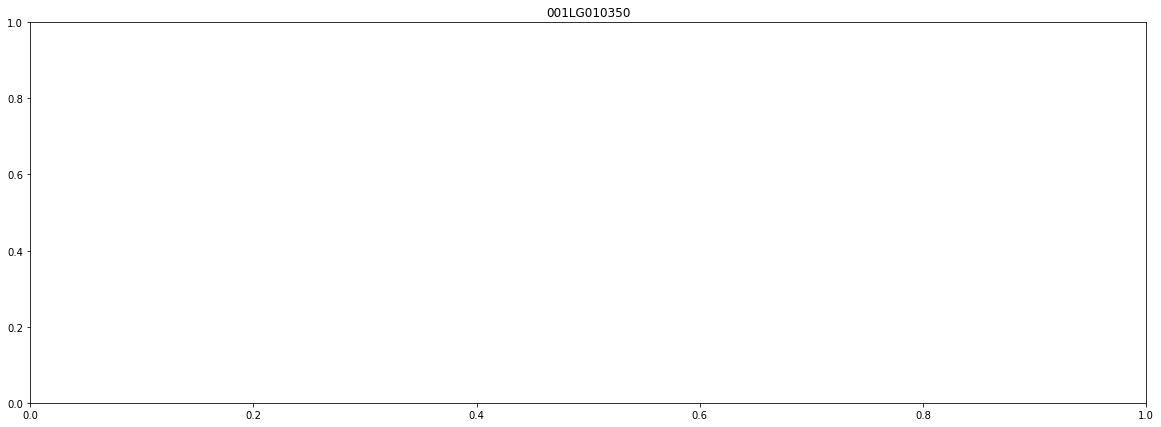

In [13]:
plot(part_number, date, dda, fc_bp, fc_aa, fc_future=None, fc_past=None, FC=False, first_date='2016-01-01', figsize=(20,7), fc_months=12)

In [12]:
part_number = 'MIL-C7515 TY I'
part_number

'MIL-C7515 TY I'

Se analiza el forecast simulado a enero-2019

Plot de la demanda histórica junto con el Forecast de Advanced junto con el Negocio

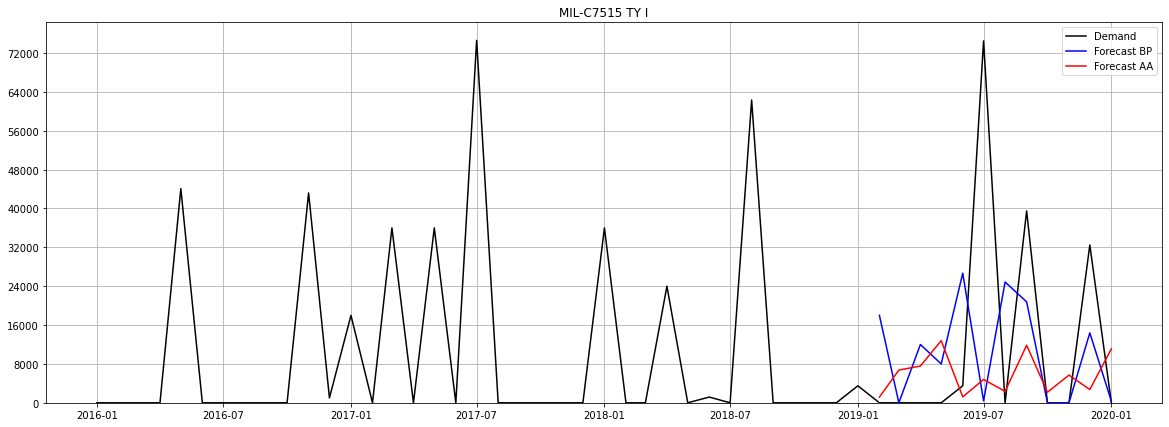

In [14]:
plot(part_number, date, dda, fc_bp, fc_aa, fc_future=None, fc_past=None, FC=False, first_date='2016-01-01', figsize=(20,7), fc_months=12)

Se calcula el Error absoluto y su diferencia

In [32]:
df = pd.DataFrame.from_dict(accuracy(part_number, date, dda, fc_bp, fc_aa, fc_months=12, FC=False), orient='index', dtype=None, columns=None)
df.columns = ['Forecast']
df = df.round()
err1 = df.copy()
err1

,Forecast
AA,79775.0
BP,24537.0
diff,-55238.0


Para testear nuevos parámetros en el modelo, se utiliza la función run_prophet

In [16]:
fc_future, fc_past = run_prophet(part_number, date, dda, growth='linear', first_date='2016-01-01',
                               interval_width=0.95, changepoint_range=0.95, changepoint_prior_scale=2.0, seasonality_mode='additive',
                               hyperparameter_tuning=False, cross_vals=1,
                               drop_outliers_winsorization=False, min_winsor=5, max_winsor=90,
                               drop_outliers_windows=False, window=12, 
                               add_regressor_FH=False, 
                               output='both', 
                               n_changepoints=10,
                               prophet_plot=False, figsize=(10,6))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Plot de la demanda histórica junto con el Forecast del Negocio y el nuevo Forecast generado

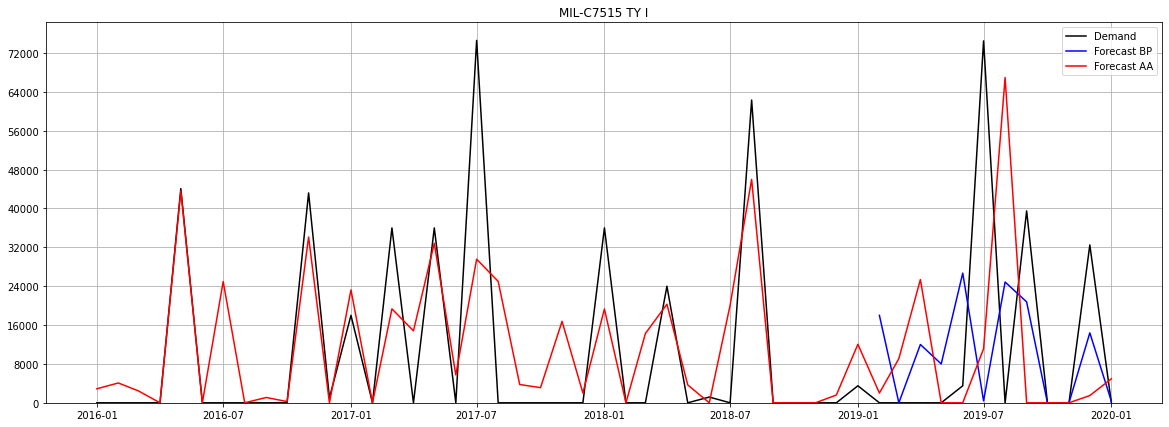

In [17]:
plot(part_number, date, dda, fc_bp, fc_aa, fc_future, fc_past, FC=True, first_date='2016-01-01', figsize=(20,7), fc_months=12)

Error absoluto

In [33]:
df = pd.DataFrame.from_dict(accuracy(part_number, date, dda, fc_bp, fc_aa, fc_future, fc_past, fc_months=12, FC=True), orient='index', dtype=None, columns=None)
df.columns = ['Testing']
df = df.round()
err2 = df.copy()
err2

,Testing
AA,29000.0
BP,24537.0
diff,-4463.0


Plot con un resumen 

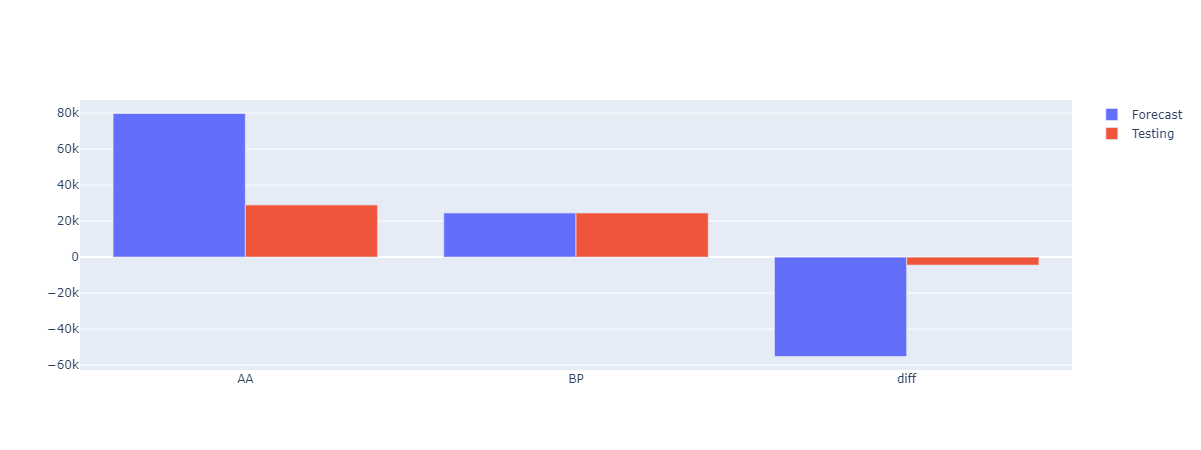

In [41]:
df = err1.merge(err2, left_index=True, right_index=True)
fig = go.Figure(data=[
    go.Bar(name='Forecast', x=df.index, y=df['Forecast']),
    go.Bar(name='Testing', x=df.index, y=df['Testing']),
])
fig.show() 

## Medición de Accuracy para una simulación de Forecast local de todos los materiales

Para copiar localmente simulaciones anteriores

In [ ]:
!gsutil cp -r gs://supply-forecast-aa/FC_RESPALDO/20210624_165451_931244/FC .

Se genera una carpeta FC donde se van guardando las simulaciones locales

- Se define la simulación a medir: fc_type
- Debe ser una carpeta definida de esta forma:
    FC/linea/fc_type/date

In [45]:
fc_type = 'CV'

PNs : 22310


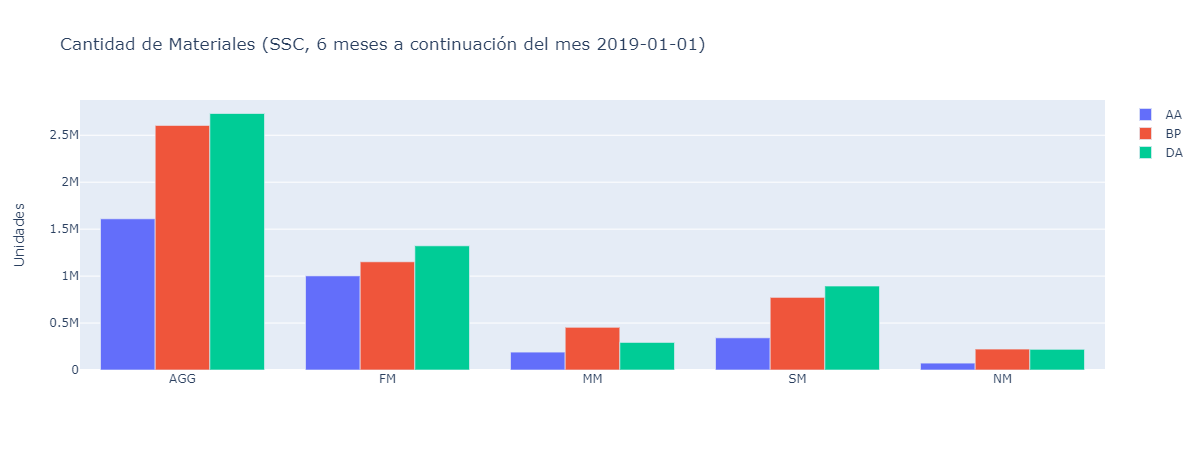

In [48]:
get_cantidad(linea, date, fc_type, PQ=False, output_data=False, output_plot=True, demand_only=False)

PNs : 22310


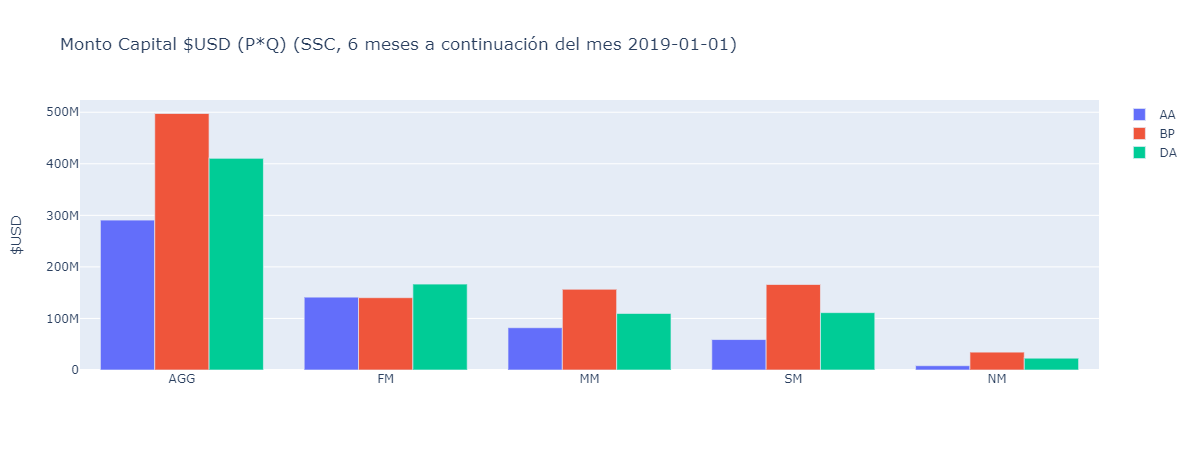

In [49]:
get_cantidad(linea, date, fc_type, PQ=True, output_data=False, output_plot=True, demand_only=False)

## Generación de una simulación de Forecast para todos los materiales

El objetivo de probar nuevos parametros es poder simular el Forecast con los nuevos parametros para todos los materiales. 

- En la carpeta FC se guardan las simulaciones locales.
- Si la carpeta FC existe, se debe eliminar.

En el archivo `fc_params.py` se definen los parámetros de la simulación 

In [1]:
params = { 
    'growth': 'flat', 
    'first_date': 'all',                          
    'interval_width': 0.95, 
    'changepoint_range': 0.95, 
    'changepoint_prior_scale': 2.0, 
    'seasonality_mode': 'additive',
    'hyperparameter_tuning': False, 
    'cross_vals': 1,
    'drop_outliers_windows': False, 
    'window': 12,
    'drop_outliers_winsorization': False, 
    'min_winsor': 5, 
    'max_winsor': 90, 
    'add_regressor_FH': False, 
    'output': 'prediction', 
    'n_changepoints': 'auto'  
}

En el archivo `fc_params.py` se espeficica si sequiere realizar una simulación de *Cross Validation* (model_type) o una simulación de parámetros fijos (params)

In [5]:
# CV=False : Simulación con params / CV=True : Simulación con Cross Validation usando model_type
CV=False

En el archivo `fc_params.py` se define los tipos de modelos para Cross Validation

In [1]:
model_type = {'linear_log': ('linear', False, False, True, False), 
              'linear_window': ('linear', False, True, False, False),
              'linear_winsor': ('linear', True, False, False, False), 
              'linear_tukey': ('linear', False, False, False, True),
              'flat_log': ('flat', False, False, True, False), 
              'flat_window': ('flat', False, True, False, False),
              'flat_winsor': ('flat', True, False, False, False), 
              'flat_tukey': ('flat', False, False, False, True)
             }

Para simular un Forecast de un PN

In [ ]:
!python cli.py -linea 'SSC' -date '2019-01-01' -pn1 -pn '006605100001-R5'

Para simular un forecast de todos los PNs

In [ ]:
!python cli.py -linea 'SSC' -date '2019-01-01' -pnall

Generará un folder donde se almacenan los forecast divididos en archivos de 1000 PNs junto con una copia de fc_params.py con los parámetros. 

Este proceso es lento, se aocnseja utilizr una VM >96 nucleos (por esa razón se simulan 1000 PNs)

Para simular un forecast con Cross Validation de outliers:

En el archivo `fc_params.py` definir:

In [6]:
CV=True

Luego, en un terminal ejecutar:

In [ ]:
!python cli.py -linea 'SSC' -date '2019-01-01' -pnall -folder 'CV_OUTLIERS'

Se puede simular el forecast definiendo parámetros según su rotación

Parámetros a simular según la rotación del PN.
Al sacar outliers se puede caer en errores, por lo que se van intentanto distintos parmétros.
Para el caso de FM:

1. params_fm1
2. params_fm2
3. params_fm3

In [ ]:
!python cli.py -linea 'SSC' -date '2019-01-01' -pnall -mparams -folder 'MPARAMS'